# Taller 02: Redes recurrentes

**Integrantes:** (*Máximo grupos de 3*)

*   Christopher García
*   Gabriel Contreras
*   <Integrante 3>



El taller tiene como objetivo construir un clasificador utilizando redes recurrentes LSTM. Para esto, se replicará el problema visto en clases para la clasificación de nombres y apellidos al País que pertenecen. Una vez terminado la implementación del taller se pide comparar la eficiencia de ambos clasificadores a partir de la matriz de confusión.

Se debe tener en cuenta que en la evaluación de resultados se deben utilizar los mismos ejemplos. Por lo que deberá evaluar simultáneamente el clasificador de red recurrente simple y la red LSTM.

Las métricas solicitadas para la comparación de ambos clasifificadores son: Tasa de acierto, presición, sensibilidad (*recall*) y f1-score.

**Referencias:**
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report 

## 1. Preparar los datos

Utilizar el código mostrado en clases para cargar y acondicionar los datos:

In [1]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

import unicodedata
import string
import glob # Esta instruccion para los nombres de un archivo dado un path
import os

PATH_TEXT = '/content/drive/My Drive/DATA/Magister Data Science/Deep Learning/data/names'

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)

# Convertir el código Unicode al texto ASCII (https://stackoverflow.com/a/518232/2809427)
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

#print(unicodeToAscii('Ślusàrski'))

# Leer los archivos y los cargaremos en un estructura de tipo diccionario
category_lines = {}
all_categories = []

def readLines(filenames):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in glob.glob(f'{PATH_TEXT}/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

print(all_categories)
print(category_lines['Spanish'][:10])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
57
18
['Dutch', 'Italian', 'Spanish', 'Czech', 'Scottish', 'Portuguese', 'Arabic', 'Greek', 'Chinese', 'Vietnamese', 'Japanese', 'French', 'German', 'Korean', 'English', 'Russian', 'Polish', 'Irish']
['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal', 'Abasolo', 'Abel', 'Abello', 'Aberquero', 'Abreu']


## 2. Preparar los datos a formato Pytorch para red neuronal recurrente

Convertirmos las palabras (apellidos y nombres) a formato ***one-hot vector***. Además se contruye a formato tensor para poder utilizar la GPU vía Pytorch.

In [2]:
import torch

# Encontrar el indice de una letra en all_letters
def letterToIndex(letter):
  return all_letters.find(letter)

# Construir un vector one-hot letter (Ilustrativo)
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1

  return tensor

print(lineToTensor('garcia'))

tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## 3. Crear modelos

Para comparar los resultados se pide construir:


*   Modelo de red neuronal recurrente simple (vista en clases)
*   Modelo de red neuronal LSTM (Implementar)



In [3]:
# Modelo de red neuronal recurrente simple
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    # Construir componentes
    self.hidden_size = hidden_size
    # Salida de estado oculto
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    # Salida a estimar
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1) # vector --> [1 x (input + hidden)]
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128

# n_letters --> Cantidad de letras que uso para representar mis palabras (57)
# n_hidden --> Tamaño del vector de estado oculto (128)
# n_categories --> La cantidad de paises (18)
rnn = RNN(n_letters, n_hidden, n_categories)


input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print(output)
print(next_hidden)

tensor([[-2.8746, -2.8677, -2.8668, -2.9768, -2.8941, -2.8973, -2.9528, -2.9020,
         -2.8433, -2.8118, -2.9046, -2.8630, -2.9945, -2.8202, -2.8583, -2.8108,
         -2.9158, -3.0008]], grad_fn=<LogSoftmaxBackward>)
tensor([[ 0.0072,  0.1282, -0.0446,  0.0326, -0.0010,  0.0282,  0.0303, -0.1076,
         -0.0062, -0.0588, -0.0104,  0.0940,  0.0080,  0.0214, -0.0022, -0.0196,
          0.0186,  0.0830,  0.0236,  0.0450, -0.0763, -0.0494, -0.0048, -0.0280,
         -0.0666,  0.0217, -0.0323,  0.0211, -0.0229, -0.0567, -0.0648, -0.1171,
          0.1447,  0.0823,  0.0296,  0.0665,  0.1350,  0.0155,  0.1205, -0.0384,
          0.1181,  0.0388,  0.1356, -0.0186,  0.0248, -0.0144, -0.0114, -0.0394,
          0.1263, -0.0697,  0.1258, -0.0741, -0.1460,  0.0166, -0.0579, -0.1141,
          0.0675,  0.0556, -0.1032,  0.0587,  0.1184,  0.0093,  0.0197,  0.0800,
         -0.0021,  0.0003,  0.0571, -0.0017, -0.0465,  0.0292, -0.0953, -0.1181,
          0.1018, -0.0260,  0.0128,  0.0531, -0.03

In [4]:
# Modelo de red neuronal LSTM

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output.view(1, -1), hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

n_hidden = 128

# n_letters --> Cantidad de letras que uso para representar mis palabras (57)
# n_hidden --> Tamaño del vector de estado oculto (128)
# n_categories --> La cantidad de paises (18)
lstm = LSTM(n_letters, n_hidden, n_categories)

## 5. Generación de ejemplos aleatorios

Como se tienen diferentes palabras y categorías es que se optó por utilizar ejemplos generados de forma aleatoria. 

Para entrenar los modelos utilizaremos los mismo ejemplos generados por `randomChoiceExample`. Se debe considerar está condición en la implementación.

In [5]:
# Implementación randomTrainingExample()
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

import random

# Elige un elemento de lista en forma aleatoria
def randomChoice(lista):
  return lista[random.randint(0, len(lista)-1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  # Selecciono la palabra (nombre) de una categoria
  line = randomChoice(category_lines[category])
  # Convertir tensores
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

print(all_categories)
for i in range(20):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('categoria=', category, '/ palabra=', line)

('Russian', 15)
['Dutch', 'Italian', 'Spanish', 'Czech', 'Scottish', 'Portuguese', 'Arabic', 'Greek', 'Chinese', 'Vietnamese', 'Japanese', 'French', 'German', 'Korean', 'English', 'Russian', 'Polish', 'Irish']
categoria= Polish / palabra= Chlebek
categoria= Japanese / palabra= Komon
categoria= Dutch / palabra= Segers
categoria= Czech / palabra= Svoboda
categoria= Polish / palabra= Majewski
categoria= Irish / palabra= Riagan
categoria= Polish / palabra= Gomolka
categoria= French / palabra= Masson
categoria= Russian / palabra= Ponasov
categoria= German / palabra= Siegel
categoria= English / palabra= Oneil
categoria= Dutch / palabra= Meeuwis
categoria= German / palabra= Knochenmus
categoria= English / palabra= Falconer
categoria= Spanish / palabra= Petit
categoria= Italian / palabra= Fierro
categoria= Greek / palabra= Karkampasis
categoria= Italian / palabra= Aiolfi
categoria= Spanish / palabra= Avana
categoria= Spanish / palabra= Abascal


## 6. Entrenamiento de los modelos

Para el entrenamiento se utilizarán los **mismos parámetros utilizados en clases para entrenar ambos modelos**. Se recomienda entrenar ambos modelos en el mismo ciclo.


In [6]:
# Definir función de pérdida para ambos modelos
criterion = nn.NLLLoss()

# Definir tasa de aprendizaje
learning_rate = 0.005

# Función de entrenamiento RNN
def train_rnn(category_tensor, line_tensor):
  # Inicializar la capa hidden en cero
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  # Actualizar los parametros del modelo
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

# Función de entrenamiento LSTM
def train_lstm(category_tensor, line_tensor):
  # Inicializar la capa hidden en cero
  hidden = lstm.init_hidden()

  lstm.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = lstm(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  # Actualizar los parametros del modelo
  for p in lstm.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

# Entrenamiento 
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Guardamos la perdida
current_loss_rnn = 0
all_losses_rnn = []
current_loss_lstm = 0
all_losses_lstm = []

def timeSince(since):
  now = time.time()
  s = now -since
  m = math.floor(s/60)
  s -= m *60
  return '%dm %ds' % (m, s)

start = time.time()

#Ciclo RNN
for iter_rnn in range(1, n_iters + 1):
  # Obtener una categoria y una palabra de forma aleatoria
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train_rnn(category_tensor, line_tensor)
  current_loss_rnn += loss

  # Imprimir los resultados
  if iter_rnn % print_every == 0: 
    guess, guess_i = categoryFromOutput(output)
    correct = 'OK' if guess == category else 'ERROR (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter_rnn, iter_rnn/n_iters * 100, timeSince(start),loss, line, guess, correct))

  if iter_rnn % plot_every == 0:
    all_losses_rnn.append(current_loss_rnn / plot_every)
    current_loss_rnn = 0

#Ciclo LSTM
for iter_lstm in range(1, n_iters + 1):
  # Obtener una categoria y una palabra de forma aleatoria
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train_lstm(category_tensor, line_tensor)
  current_loss_lstm += loss

  # Imprimir los resultados
  if iter_lstm % print_every == 0: 
    guess, guess_i = categoryFromOutput(output)
    correct = 'OK' if guess == category else 'ERROR (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter_lstm, iter_lstm/n_iters * 100, timeSince(start),loss, line, guess, correct))

  if iter_lstm % plot_every == 0:
    all_losses_lstm.append(current_loss_lstm / plot_every)
    current_loss_lstm = 0

5000 5% (0m 4s) 1.8723 Gabrielli / Italian OK
10000 10% (0m 9s) 2.2863 Viteri / Italian ERROR (Spanish)
15000 15% (0m 14s) 1.3159 To / Vietnamese OK
20000 20% (0m 18s) 6.9050 Park  / Polish ERROR (Korean)
25000 25% (0m 23s) 1.5666 Sayegh / Arabic OK
30000 30% (0m 28s) 1.7147 Mcintosh / Italian ERROR (Scottish)
35000 35% (0m 33s) 0.1295 Zhestkov / Russian OK
40000 40% (0m 37s) 3.1973 Close / Irish ERROR (Greek)
45000 45% (0m 42s) 0.2355 Atshushi / Japanese OK
50000 50% (0m 46s) 2.4161 Rhys / Korean ERROR (Irish)
55000 55% (0m 51s) 2.5542 D'aramitz / Irish ERROR (French)
60000 60% (0m 56s) 3.4441 Gillespie / Italian ERROR (English)
65000 65% (1m 0s) 0.8568 Herbert / German OK
70000 70% (1m 5s) 2.2411 Pae / Vietnamese ERROR (Korean)
75000 75% (1m 10s) 1.4286 Chang / Vietnamese ERROR (Korean)
80000 80% (1m 14s) 2.4960 Gaspar / Arabic ERROR (Spanish)
85000 85% (1m 19s) 0.1654 Horiatis / Greek OK
90000 90% (1m 24s) 1.1654 Jordan / Polish OK
95000 95% (1m 28s) 4.8905 Weichert / Dutch ERROR (C

## 7. Graficar resultados

Graficar la función de pérdida para ambos modelos.

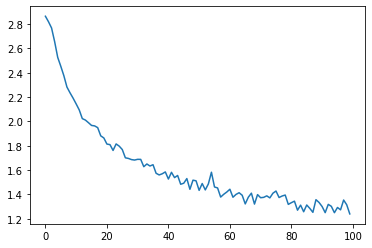

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses_rnn)

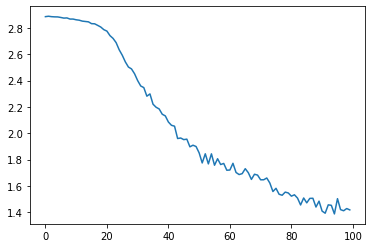

In [10]:
plt.figure()
plt.plot(all_losses_lstm)

### 7.1 Comparar los resultados

<< Discutir los resultados obtenidos en las gráficas>>

## 8. Evaluar los resultados

Construir las **matrices de confusión** para los dos modelos (RNN y LSTM). Indicando en cada fila el idioma real y en las columnas el idioma predicho. Graficar matriz de confusión como la vista en clases.

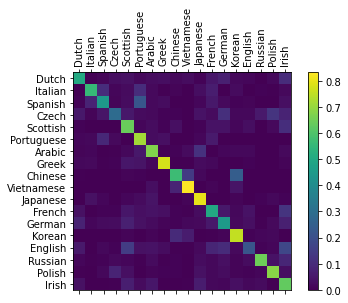

In [37]:
#Matriz para RNN

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate_rnn(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_rnn(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

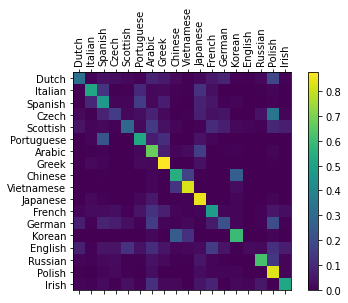

In [24]:
#Matriz de confusión para LSTM

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate_lstm(line_tensor):
    hidden = lstm.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### 8.1 Calcular métricas

Calcular tasa de acierto, presición, sensibilidad (recall) y f1-score para ambos modelos. Comparar sus resultados

### 8.2 Comparar resultados

<< Explicar resultados>>

In [90]:
from sklearn.metrics import classification_report

y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]

target_names = ['class 0', 'class 1', 'class 2']

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



## 9. Probar ambos modelos

Probar ambos modelos con las palabras: Dovesky, Jackson, Satoshi, Bekios y su apellido o nombre.

In [31]:
#RNN
def predict_rnn(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate_rnn(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict_rnn('Dovesky')
predict_rnn('Jackson')
predict_rnn('Satoshi')
predict_rnn('Bekios')
predict_rnn('Garcia')


> Dovesky
(-0.47) Russian
(-1.94) Czech
(-2.59) Irish

> Jackson
(-0.65) Scottish
(-1.34) English
(-2.75) Russian

> Satoshi
(-0.63) Japanese
(-1.95) Italian
(-2.27) Arabic

> Bekios
(-0.89) Greek
(-1.82) Arabic
(-2.35) English

> Garcia
(-0.86) Spanish
(-1.61) Portuguese
(-1.82) Arabic


In [32]:
#LSTM predict

def predict_lstm(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate_lstm(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict_lstm('Dovesky')
predict_lstm('Jackson')
predict_lstm('Satoshi')
predict_lstm('Bekios')
predict_lstm('Garcia')


> Dovesky
(-1.03) Czech
(-1.10) Polish
(-1.42) Russian

> Jackson
(-0.73) Scottish
(-1.71) Polish
(-2.21) English

> Satoshi
(-0.18) Japanese
(-2.39) Arabic
(-3.07) Polish

> Bekios
(-0.19) Greek
(-3.43) Arabic
(-3.52) Portuguese

> Garcia
(-0.59) Portuguese
(-1.46) Spanish
(-2.24) Italian
